In [270]:
import os
import random
import re
import shutil
import copy
import pandas as pd

'''
flag: 1. default: list all dir (dir doesn't need end with number)
      2. sorted: the dir must have common prefix and end with number
      3. shuffled: dir doesn't need end with number
'''

def listAllSubDir(path, flag="default"):
    pathList = []
    for item in os.listdir(path):
        if os.path.isdir(path + "/" + item) and item[0] != ".":
            pathList.append(path + "/" + item)
            
    if flag == "default":
        pass
    if flag == "sorted":
        pathList = sortByLastNumber(pathList)
    if flag == "shuffled":
        pathList = random.shuffle(pathList)
    return pathList


def listAllSubFile(path, flag="default"):
    fileList = []
    for item in os.listdir(path):
        if os.path.isfile(path + "/" + item) and item[0] != ".":
            fileList.append(path + "/" + item)
            
    if flag == "default":
        pass
    if flag == "sorted":
        fileList = sortByLastNumber(fileList)
    if flag == "shuffled":
        fileList = random.shuffle(fileList)
    return fileList


def sortByLastNumber(lst):
    tupleList = []
    for item in lst:
        numbers = re.findall(r'[\d]+', item)
        tupleList.append((int(numbers[-1]), item))  # sort by the last number
    tupleList.sort()
    
    stringList = []
    for item in tupleList:
        stringList.append(item[1])
    return stringList

def safeCreateDir(dirName):
    # Check whether the specified path exists or not
    isExist = os.path.exists(dirName)
    if isExist:
        # delete
        shutil.rmtree(dirName)
    
    os.makedirs(dirName)



In [271]:
# create problem structure
# problemStructure[envId][goalId][caseId]

def createProblemStructure(rootPath):
    problemStructure = []
    numberOfEnv = 0
    numberOfGoal = 0
    numberOfCase = 0

    envList = listAllSubDir(rootPath, "sorted")
    numberOfEnv = len(envList)
    for env in envList:
        tmpList = []
        goalList = listAllSubDir(env, "sorted")
        numberOfGoal = len(goalList)
        for goal in goalList:
            caseList = listAllSubFile(goal, "sorted")
            numberOfCase = len(caseList)
            tmpList.append(caseList)

        problemStructure.append(tmpList)
        
    return numberOfEnv, numberOfGoal, numberOfCase, problemStructure

# main
numberOfEnv, numberOfGoal, numberOfCase, problemStructure = createProblemStructure("changed")

In [272]:
class DriftGenerator:
    def __init__(self, numberOfEnv, numberOfGoal, numberOfCase, problemStructure):
        self.numberOfEnv = numberOfEnv
        self.numberOfGoal = numberOfGoal
        self.numberOfCase = numberOfCase
        self.problemStructure = problemStructure
        
    # eg: numberPerCase = 200
    # sudden drift: drift happen when each goal have selected "numberPerCase" of cases
    def sudden(self, numberPerCase):
        dstDir = "sudden"
        safeCreateDir(dstDir)
        
        caseID = []
        env = []
        goal = []
        
        caseCount = 0
        envId = 0
        while envId < self.numberOfEnv:
            currCollected = 0
            while currCollected < numberPerCase:
                goalId = random.randint(0, self.numberOfGoal-1)
                case = problemStructure[envId][goalId][currCollected]
                # print(case)

                caseCount += 1
                caseID.append(caseCount)
                env.append(envId)
                goal.append(goalId+1)

                copyName = "sas_plan.%s" % str(caseCount)
                shutil.copyfile(case, dstDir + "/" + copyName)        
                currCollected += 1
            envId += 1
            
        d = {"caseID": caseID, "env": env, "goal": goal}
        df = pd.DataFrame(data=d)
        return df
        
        
            
    # numberPerCase = 200, reoccurTimes = 3, 
    def reoccuring(self, numberPerCase, reoccurTimes):
        dstDir = "reoccuring"
        safeCreateDir(dstDir)
        
        caseID = []
        env = []
        goal = []
               
        caseCount = 0
        copyStructure = copy.deepcopy(self.problemStructure)
        reoccurCount = 0
        while reoccurCount < reoccurTimes:
            envId = 0
            while envId < self.numberOfEnv:
                currCollected = 0
                while currCollected < numberPerCase:
                    goalId = random.randint(0, self.numberOfGoal-1)
                    # need pop out the first item
                    case = copyStructure[envId][goalId].pop(0)

                    caseCount += 1
                    caseID.append(caseCount)
                    env.append(envId)
                    goal.append(goalId+1)

                    copyName = "sas_plan.%s" % str(caseCount)
                    shutil.copyfile(case, dstDir + "/" + copyName) 
                    currCollected += 1
                envId += 1
            reoccurCount += 1
            
        d = {"caseID": caseID, "env": env, "goal": goal}
        df = pd.DataFrame(data=d)
        return df
            
        
     
    # numberPerCase = 200, graduateChangeCases = 100
    def gradual(self, numberPerCase, graduateChangeCases, periodList = ["normal", "gradual", "normal"]):
        dstDir = "gradual"
        safeCreateDir(dstDir)
        
        caseCount = 0
        copyStructure = copy.deepcopy(self.problemStructure)
        envIdList = [0, 1]
        increasingProbStep = 100/graduateChangeCases
        probEnv0 = 100
        probEnv1 = 0
        
        caseID = []
        env = []
        goal = []

        for period in periodList:

            # normal period:
            if period == "normal":
                currCollected = 0
                while currCollected < numberPerCase:
                    envId = random.choices(envIdList, weights=(probEnv0, probEnv1), k=1)[0] # only one item in the list
                    goalId = random.randint(0, self.numberOfGoal-1)
                    case = copyStructure[envId][goalId].pop(0)

                    caseCount += 1
                    caseID.append(caseCount)
                    env.append(envId)
                    goal.append(goalId+1)

                    copyName = "sas_plan.%s" % str(caseCount)
                    shutil.copyfile(case, dstDir + "/" + copyName) 
                    currCollected += 1

            # gradual period
            if period == "gradual":
                currCollected = 0
                while currCollected < graduateChangeCases:

                    
                    envId = random.choices(envIdList, weights=(probEnv0, probEnv1), k=1)[0]
                    probEnv0 -= increasingProbStep
                    probEnv1 += increasingProbStep
                    
                    goalId = random.randint(0, self.numberOfGoal-1)

                    case = copyStructure[envId][goalId].pop(0)

                    caseCount += 1
                    caseID.append(caseCount)
                    env.append(envId)
                    goal.append(goalId+1)

                    copyName = "sas_plan.%s" % str(caseCount)
                    shutil.copyfile(case, dstDir + "/" + copyName)
                        
                    currCollected += 1
                    
        d = {"caseID": caseID, "env": env, "goal": goal}
        df = pd.DataFrame(data=d)
        return df
    
    # probOutlier = 0.05, numberPerCase = 300
    def outlier(self, numberPerCase, probOutlier):
        dstDir = "outlier"
        safeCreateDir(dstDir)
        
        caseCount = 0
        copyStructure = copy.deepcopy(self.problemStructure)
        probNormal = 1 - probOutlier
        envIdList = [0, 1]
        currCollected = 0
        
        caseID = []
        env = []
        goal = []
        
        while currCollected < numberPerCase:
            envId = random.choices(envIdList, weights=(probNormal, probOutlier), k=1)[0] # only one item in the list
            goalId = random.randint(0, self.numberOfGoal-1)
            case = copyStructure[envId][goalId].pop(0)

            caseCount += 1
            caseID.append(caseCount)
            env.append(envId)
            goal.append(goalId+1)

            copyName = "sas_plan.%s" % str(caseCount)
            shutil.copyfile(case, dstDir + "/" + copyName)
            currCollected += 1
            
        d = {"caseID": caseID, "env": env, "goal": goal}
        df = pd.DataFrame(data=d)
        return df
    
    
    
    def incremental(self, numberPerCase, numEnv):
        dstDir = "incremental"
        safeCreateDir(dstDir)
        
        caseID = []
        env = []
        goal = []
        
        caseCount = 0
        envId = 0
        
        not_intermediate = True
        
        while envId < self.numberOfEnv:
            if not_intermediate:
                currCollected = 0
                while currCollected < numberPerCase:
                    goalId = random.randint(0, self.numberOfGoal-1)
                    case = problemStructure[envId][goalId][currCollected]
                    # print(case)

                    caseCount += 1
                    caseID.append(caseCount)
                    env.append(envId/numEnv)
                    goal.append(goalId+1)

                    copyName = "sas_plan.%s" % str(caseCount)
                    shutil.copyfile(case, dstDir + "/" + copyName)        
                    currCollected += 1
                envId += 1
                not_intermediate = False
            else:
                currCollected = 0
                goalId = random.randint(0, self.numberOfGoal-1)
                case = problemStructure[envId][goalId][currCollected]
                # print(case)

                caseCount += 1
                caseID.append(caseCount)
                env.append(envId/numEnv)
                goal.append(goalId+1)

                copyName = "sas_plan.%s" % str(caseCount)
                shutil.copyfile(case, dstDir + "/" + copyName)        
                currCollected += 1
                
                envId += 1
                if envId == numEnv:
                    not_intermediate = True
                    
                
                
            
        d = {"caseID": caseID, "env": env, "goal": goal}
        df = pd.DataFrame(data=d)
        return df
        
        
        
dg = DriftGenerator(numberOfEnv, numberOfGoal, numberOfCase, problemStructure)




In [273]:
# sudden drift
# df = dg.sudden(5)

# reoccuring drift, drift happened 3 times
# df = dg.reoccuring(4, 2)

# gradual changing period for 100 cases per goal
df = dg.gradual(50, 50)

# chance of a outlier occur is 0.05
# df = dg.outlier(10, 0.1)

# incremental
# df = dg.incremental(4, 5)

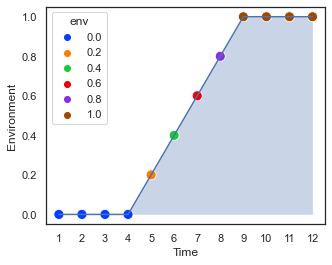

In [269]:
# Import seaborn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Apply the default theme
# sns.set_theme()
sns.set(rc = {'figure.figsize':(5,4)}, style='white')

x = df["caseID"]
y = df["env"]

plt.xlabel("Time")
plt.ylabel("Environment")

# plt.yticks([0, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.plot(x, y)
plt.fill_between(x, y, alpha=0.30)
# Create a visualization
sns.scatterplot(data=df, x="caseID", y="env", hue="env", palette="bright", s=100)

plt.savefig('exp_incremental.pdf')

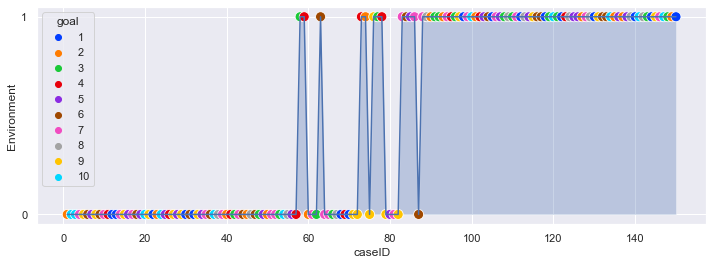

In [274]:
# Import seaborn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Apply the default theme
# sns.set_theme()
sns.set(rc = {'figure.figsize':(12,4)})

x = df["caseID"]
y = df["env"]

plt.xlabel("caseID")
plt.ylabel("Environment")


plt.yticks([0, 1])
plt.plot(x, y)
plt.fill_between(x, y, alpha=0.30)
# Create a visualization
sns.scatterplot(data=df, x="caseID", y="env", hue="goal", palette="bright", s=100)

plt.savefig('data_gradual.pdf')

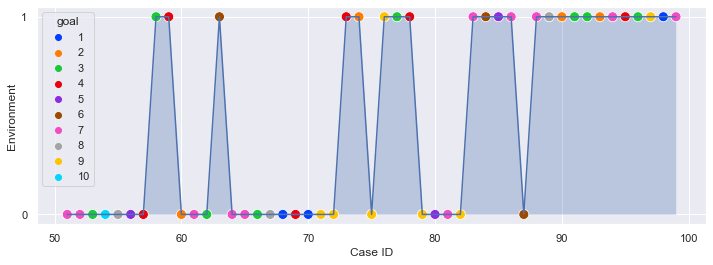

In [275]:
# visual of smaller window:

# start = 391
# end = 410

start = 51
end = 100

# start = 101
# end = 150

selectWindow = df[start-1:end-1]

# sns.set_theme()
sns.set(rc = {'figure.figsize':(12,4)})


x = selectWindow["caseID"]
y = selectWindow["env"]

plt.xlabel("Case ID")
plt.ylabel("Environment")


plt.yticks([0, 1])
plt.plot(x, y)
plt.fill_between(x, y, alpha=0.30)




# Create a visualization
sns.scatterplot(data=selectWindow, x="caseID", y="env", hue="goal", palette="bright", s=100)

plt.savefig('window_gradual.pdf')